<a href="https://colab.research.google.com/github/YeweiYuan/Quantum-Pricing/blob/main/qfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

功能性函数
---

---
辅助工具

In [2]:
!pip install pyqpanda

In [4]:
import pyqpanda.pyQPanda as pq
import math
import matplotlib.pyplot as plt
import numpy as np

In [32]:
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU)
n=2
qlist = m_machine.qAlloc_many(n)

def QH(qbits,circuit=pq.create_empty_circuit()):  #批量对qbits进行H门
  for i in range(len(qbits)):
    circuit.insert(pq.H(qbits[i]))
  
  return circuit

def phasee(qbits, operator=QH, qprog=pq.QProg, m=2): #相位估计，输入qbits,估计的算子，先前的量子程序，和用于相位估计的比特数
  anc = m_machine.qAlloc_many(m)
  clist = m_machine.cAlloc_many(m)
  for i in range(m):
    qprog.insert(pq.H(anc[i]))
    qprog.insert(operator(qlist)).control(anc[i])
  
  qprog.insert(pq.QFT(anc).dagger())
  qprog.insert(pq.measure_all(anc,clist))
  result = m_machine.run_with_configuration(qprog,clist,1000)
  print(result)

In [33]:
QH(qlist)

In [34]:
#检验批量H门
qprog = pq.QProg
qprog.insert(QH(qlist))
clist = m_machine.cAlloc_many(n)
res = m_machine.prob_run_tuple_list(qprog,qlist,-1)
print(res)

pq.draw_qprog(prog)

TypeError: ignored

In [28]:
def QH2(qbits,qprog=pq.QProg()):  #批量对qbits进行H门
  for i in range(len(qbits)):
    qprog.insert(pq.H(qbits[i]))
  pq.draw_qprog(qprog)
  return qprog

qprog = QH2(qlist)
clist = m_machine.cAlloc_many(n)
res = m_machine.prob_run_tuple_list(qprog,qlist,-1)
print(res)

{'00': 0.2499999701976776, '01': 0.2499999701976776, '10': 0.2499999701976776, '11': 0.2499999701976776}


In [23]:
#检验相位估计
qprog = pq.QProg
phasee(qlist)

TypeError: ignored

量子期权定价
---



---
蒙特卡罗方法和bsm



In [2]:
import numpy as np
from scipy.stats import norm
from numpy.random import standard_normal
import matplotlib.pyplot as plt

In [3]:
class Sampling:
  def __init__(self,N=10000,T=365,S_0=5,K=5.5,Rate=0.04,Sigma=0.24,steps=100): #初始化一年的股票欧式期权，标的资产股票价格为5元，期权执行价格为6元，年化无风险利率和年化波动率分别为4%和24%，模拟10000次
    self.N = N # sample size
    self.T = T/365 # time
    self.S_0 = S_0 # init price
    self.Rate = Rate # rate
    self.Sigma = Sigma # volatility
    self.K = K # strike price
    self.steps = steps #二叉树取节点数默认1年100次

  def callMonteCarlo(self): #蒙特卡罗法，看涨期权
    z = standard_normal(self.N)
    S_t = self.S_0*np.exp((self.Rate-0.5*self.Sigma**2)*self.T+self.Sigma*z*np.sqrt(self.T))
    call = np.maximum(0,S_t-self.K)
    res = sum(call)*(np.exp(-self.Rate*self.T))/self.N
    return res
  
  def callBSM(self): #BSM模型，看涨期权
    d1 = (np.log(self.S_0/self.K)+(self.Rate*self.T))/ \
    (self.Sigma*np.sqrt(self.T))+0.5*self.Sigma*np.sqrt(self.T)
    d2 = d1-self.Sigma*np.sqrt(self.T)
    call = self.S_0*norm.cdf(d1,0.0,1.0)-self.K*np.exp(-self.Rate*self.T)*norm.cdf(d2,0.0,1.0)
    return call

  def callBin(self): #二叉树模型，看涨期权
    u=np.exp(self.Sigma*np.sqrt(self.T/self.steps))
    d=1/u
    P=(np.exp(self.Rate*self.T/self.steps)-d)/(u-d)
    S_t = [[] for i in range(self.steps+1)]
    call = [[] for i in range(self.steps+1)] 
    S_t[0]=self.S_0*d**self.steps #最后一行最后一列的股票价格
    call[0]=np.maximum(S_t[0]-self.K,0) #最后一行最后一列的期权价值
    for i in range(1,self.steps+1):
      S_t[i]=S_t[i-1]*(u**2) #计算最后一列的股票价格
      call[i]=np.maximum(S_t[i]-self.K,0) #计算最后一列的期权价值
    for j in range(self.steps,0,-1): #逐个节点往前计算
      for i in range(0,j):
        call[i]=(P*call[i+1]+(1-P)*call[i])/np.exp(self.Rate*self.T/self.steps)
    return call[0]


In [ ]:
test = Sampling()

In [ ]:
print('MonteCarlo: %f \nBSM: %f \nBIN: %f'%(test.callMonteCarlo(),test.callBSM(),test.callBin()))

MonteCarlo: 0.364538 
BLM: 0.361912 
BIN: 0.360706


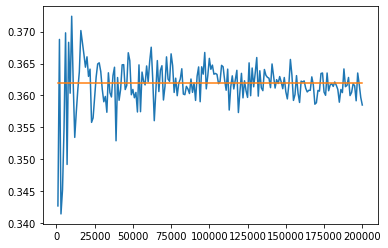

In [10]:
MC = []
for i in range(1000,201000,1000):
  test = Sampling(N=i)
  MC.append(test.callMonteCarlo())
BSM = [test.callBSM()]*200
plt.plot(range(1000,201000,1000),MC)
plt.plot(range(1000,201000,1000),BSM)

---
量子方法

In [11]:
!pip install pyqpanda

     |████████████████████████████████| 20.8MB 1.3MB/s 


In [12]:
import pyqpanda.pyQPanda as pq
import math

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy.random import standard_normal

In [18]:
class Qsampling:
  def __init__(self,N=6,M=3,T=365,S_0=5,K=5.5,Rate=0.04,Sigma=0.24,machineType=pq.QMachineType.CPU,c=0.1): #3个用于拟合分布的qubits(2^(-n)的误差)，3个用于相位估计的qubits，1个ancilla qubit
    self.N = N
    self.M = M
    self.T = T/365 # time
    self.S_0 = S_0 # init price
    self.Rate = Rate # rate
    self.Sigma = Sigma # volatility
    self.K = K # strike price
    self.m_machine = pq.init_quantum_machine(machineType)
    self.m_qlist = self.m_machine.qAlloc_many(N+M+2)
    self.m_clist = self.m_machine.cAlloc_many(N+M+2)  #初始构造全部的比特吗，还是后续可以陆续添加
    self.m_prog = pq.QProg()
    self.c = c #s an additional scaling parameter

  def __del__(self):
    pq.destroy_quantum_machine(self.m_machine)

  def sample(self):  #使用sample函数对布朗运动进行采样
    x_max = np.sqrt(self.T)*3 #这里取3倍标准差涵盖99.7的分布
    delta = 2*x_max/(2**self.N-1)
    x_j = []
    p_j = []
    for j in range(2**self.N):
      x_j.append(-x_max+j*delta)
    for j in range(2**self.N):
      p_j.append(norm.pdf(-x_max+j*delta))
    p_j = np.array(p_j)/sum(p_j)
    '''
    未完成的手动量子态振幅编码程序
    p_mk = [[] for i in range(self.N)]
    for m in range(self.N):
      for k in range(2**(m+1)):
        p_mk[m].append(sum(p_j[k*2**(self.N-m-1):(k+1)*2**(self.N-m-1)]))
 
    theta_mk = [[] for i in range(self.N-1)]
    for m in range(self.N-1):
      for k in range(2**(m+1)):
        theta_mk[m].append(np.arccos(np.sqrt(p_mk[m+1][2*k]/p_mk[m][k])))
    '''
    qlist = self.m_qlist
    cir_encode = pq.amplitude_encode(qlist[0:self.N],p_j)
    self.m_prog.insert(cir_encode)
    #print(p_j)
    print(x_j)
    #self.m_prog.insert(pq.Measure(qlist[1],self.m_clist[1]))
    #res = self.m_machine.run_with_configuration(self.m_prog,m_clist,1000)

    res = self.m_machine.prob_run_tuple_list(self.m_prog,qlist[0:self.N],-1)
    #print(res.values())

    plt.plot(x_j,p_j)
    plt.plot(x_j,list(res.values()))
    return x_j,p_j #返回取样点和取样点的概率

  def expectation(self): #使用expectation函数把采样的布朗运动映射到对应的期权价格并给出期望
    x_j = self.sample()[0]
    '''
    v_x = []
    for x in x_j:
      v_x.append(max(0,self.S_0*np.exp((self.Rate-0.5*self.Sigma**2)*self.T+self.Sigma*x)-self.K))
    print(v_x)
    这里文献1试图把v_x编入量子电路中直接测量，但是需要各种量子电路上的算数运算，他也没给具体实现方法，想了一整天没想出来怎么操作
    '''


  
  def qbin(self):
    print('uncompleted')


[-3.0, -2.9047619047619047, -2.8095238095238093, -2.7142857142857144, -2.619047619047619, -2.5238095238095237, -2.428571428571429, -2.3333333333333335, -2.238095238095238, -2.142857142857143, -2.0476190476190474, -1.9523809523809526, -1.8571428571428572, -1.7619047619047619, -1.6666666666666667, -1.5714285714285716, -1.4761904761904763, -1.380952380952381, -1.2857142857142858, -1.1904761904761907, -1.0952380952380953, -1.0, -0.9047619047619051, -0.8095238095238098, -0.7142857142857144, -0.6190476190476191, -0.5238095238095237, -0.4285714285714288, -0.3333333333333335, -0.23809523809523814, -0.14285714285714324, -0.047619047619047894, 0.04761904761904745, 0.1428571428571428, 0.23809523809523814, 0.33333333333333304, 0.4285714285714284, 0.5238095238095237, 0.6190476190476186, 0.714285714285714, 0.8095238095238093, 0.9047619047619047, 1.0, 1.095238095238095, 1.1904761904761898, 1.2857142857142856, 1.3809523809523805, 1.4761904761904763, 1.5714285714285712, 1.666666666666666, 1.76190476190

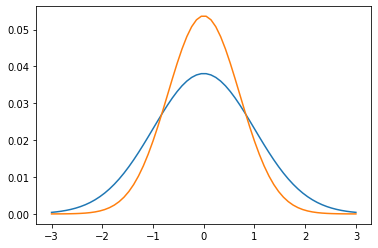

In [19]:
Qtest = Qsampling()
Qtest.expectation()

[0.00018047 0.00018206 0.00018367 ... 0.00018367 0.00018206 0.00018047]
dict_values([2.606293674034532e-05, 2.6525125576881692e-05, 2.699458309507463e-05, 2.747140206338372e-05, 2.7955682526226155e-05, 2.844751907105092e-05, 2.8947009923285805e-05, 2.9454260584316216e-05, 2.9969374736538157e-05, 3.0492439691442996e-05, 3.102356640738435e-05, 3.1562864023726434e-05, 3.211044167983346e-05, 3.2666383049217984e-05, 3.3230800909223035e-05, 3.3803815313149244e-05, 3.43855244864244e-05, 3.4976044844370335e-05, 3.557548188837245e-05, 3.618394839577377e-05, 3.6801571695832536e-05, 3.7428435462061316e-05, 3.806465974776074e-05, 3.8710371882189065e-05, 3.93656846426893e-05, 4.003071808256209e-05, 4.070557770319283e-05, 4.139039447181858e-05, 4.2085288441739976e-05, 4.279036875232123e-05, 4.350578456069343e-05, 4.4231623178347945e-05, 4.496801193454303e-05, 4.571510726236738e-05, 4.6473011025227606e-05, 4.724186146631837e-05, 4.8021764087025076e-05, 4.881287895841524e-05, 4.9615311581874266e-05, 5

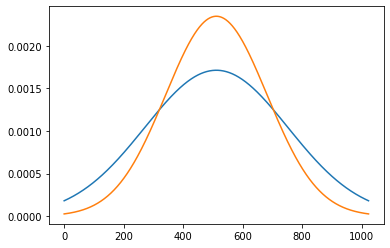

In [ ]:
Qtest = Qsampling()
Qtest.sample()

In [ ]:
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU)
N=10
M=3
m_qlist = m_machine.qAlloc_many(3)
m_clist = m_machine.cAlloc_many(3)
prog = pq.QProg()
prog.insert(pq.Measure(m_qlist[1],m_clist[1])) #这里只测量第二个比特
result = m_machine.run_with_configuration(prog, m_clist[1], 1000)

print(result)

#这边第一个问题是文档描述Measure是测量单比特的但是并没有给实例，我运行了一下他好像还是对所有比特进行了测量
#而且一个不方便的事情是只有Measure和measure_all两个测量函数，其中Measure对象只能是单比特不能是列表，
#而measure_all的对象也很迷惑我尝试对其参数输入部分比特的列表和全部比特得到的结果都是全部比特的测量结果，其输出是和Measure一样的

{'000': 1000}
